# INIT

## Import and load the original data

In [41]:
import sys
sys.path.insert(1, '../') 
from utils.loader import Loader
from utils.data_processor import Data_processor
from utils.evaluator import Evaluator

from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, log_loss

import pandas as pd
from sklearn import tree
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.naive_bayes import GaussianNB
import prince
import numpy as np

In [2]:
data = Loader.load_by_fueltype("Eléctrico")
label_encoder = LabelEncoder()
data["price_categ"].value_counts()

/home/lingfeng/Desktop/repos/Cars_Price_Prediction/Trees/../utils/loader.py:153: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
/home/lingfeng/Desktop/repos/Cars_Price_Prediction/Trees/../utils/loader.py:153: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
/home/lingfeng/Desktop/repos/Cars_Price_Prediction/Trees/../utils/loader.py:165: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the 

price_categ
Middle low range     1353
Luxury               1182
Premiun              1113
Middle range          820
High end              767
Middle high range     727
Budget                483
Low end               141
Very low end            5
Name: count, dtype: int64

### Describe some columns
A more detailed version of the dataset can be found in the DataDescription.ipynb

In [3]:
data.select_dtypes(include=['category'])

,color,brand,model,version,fuelType,bodyTypeId,transmissionTypeId,province,environmentalLabel,jato_classification,...,Acabado Exterior_Pintura,Acabado Exterior_Rueda,AC_Zones,AC_Type,Metodo_Apertura,Tipo_Faro,interior_clock,arm_suppport_front,arm_suppport_back,price_categ
idx,,,,,,,,,,,,,,,,,,,,,
47362,Azul,SKODA,Citigo,CITIGOe iV Style 61kW 83CV Auto.,Eléctrico,Berlina,Automatico,Madrid,0,L1,...,pintura solida,no tiene,MONOZONA,AUTO,Mando a distancia,Otro,no tiene,no tiene,no tiene,Budget
47511,Gris / Plata,BMW,i3,94ah,Eléctrico,Berlina,Automatico,Madrid,0,B1,...,pintura bicolor solida,no tiene,MONOZONA,STANDARD,Teléfono móvil,LED,no tiene,no tiene,no tiene,Middle low range
47535,Azul,RENAULT,ZOE,Life R240,Eléctrico,Berlina,Automatico,Madrid,0,B1,...,pintura solida,no tiene,MONOZONA,AUTO,Mando a distancia,Otro,no tiene,no tiene,no tiene,Low end
47559,Negro,BMW,i3,S 120ah,Eléctrico,Berlina,Automatico,Vizcaya,0,B1,...,pintura bicolor solida,no tiene,MONOZONA,STANDARD,Teléfono móvil,LED,no tiene,no tiene,no tiene,Middle low range
47603,Gris / Plata (Gris),RENAULT,ZOE,Zen 100 kW R135 Bateria 50kWh,Eléctrico,Berlina,Automatico,Madrid,0,L1,...,pintura solida,no tiene,MONOZONA,AUTO,Tarjeta/llave inteligente,LED,no tiene,no tiene,no tiene,Middle low range
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94291,Blanco,DACIA,Spring,Comfort Plus Electric 33kW 45CV,Eléctrico,Berlina,Automatico,Valladolid,0,L1,...,pintura solida,no tiene,MONOZONA,STANDARD,Mando a distancia,LED,no tiene,no tiene,no tiene,Budget
94342,Blanco,HYUNDAI,Kona,EV 100kW 136CV Tecno,Eléctrico,SUV,Automatico,Barcelona,NaN,M2,...,pintura perlada,no tiene,MONOZONA,AUTO,Tarjeta/llave inteligente,LED,no tiene,Tiene,Tiene,Middle low range
94359,Negro,TESLA,Model S,Ludicrous Performance 4WD,Eléctrico,Berlina,Automatico,Madrid,0,S1,...,pintura metalizada,no tiene,BIZONA,AUTO,Tarjeta/llave inteligente,LED,no tiene,Tiene,no tiene,Luxury


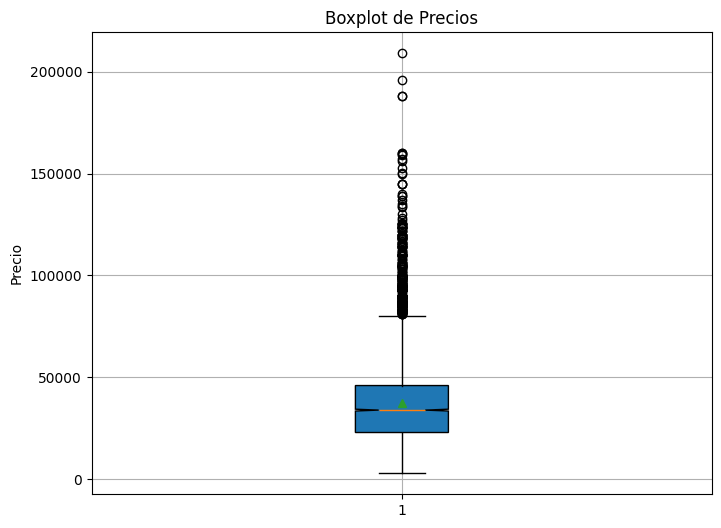

In [4]:
precios_electricos = data["price"]
plt.figure(figsize=(8, 6))
plt.boxplot(precios_electricos, notch=True, vert=True, patch_artist=True, showmeans=True)
plt.title('Boxplot de Precios')
plt.ylabel('Precio')
plt.grid(True)
plt.show()

The related outliers were checked manually throught the data source, and we could confirmed that they are not outliers

In [5]:
Q1 = data['price'].quantile(0.25)
Q2 = data['price'].quantile(0.5)  # Esta es la mediana
Q3 = data['price'].quantile(0.75)
IQR = Q3 - Q1

upper_whisker = (Q3 + 1.5 * IQR)
print(upper_whisker)

data[data["fuelType"] == "Eléctrico"][data["price"]>upper_whisker][["price", "brand"]].sort_values(by='price', ascending=False)

80525.0


,price,brand
idx,,
28269,209000,MASERATI
85726,196000,MASERATI
144182,188000,MERCEDES-BENZ
134773,188000,MERCEDES-BENZ
21981,159900,PORSCHE
...,...,...
1917,81400,MERCEDES-BENZ
43135,80900,LEXUS
43136,80900,LEXUS


# Electric cars

## Numerical variables selection Eléctrico
Here we will perform PCA and use correlation matrix to select the most correlated numerical variables

In [6]:
def fill_electric_numerical_columns(numerical_columns: pd.DataFrame) -> pd.DataFrame:
    #fill the elemental columns that has a minor amount of missing data with the mode
    numerical_columns = Data_processor.fill_na_with_mode(numerical_columns, "dimensions.length")
    numerical_columns = Data_processor.fill_na_with_mode(numerical_columns, "dimensions.height")
    numerical_columns = Data_processor.fill_na_with_mode(numerical_columns, "electricFeatures.maximumBatteryKWH_kWh")
    numerical_columns = Data_processor.fill_na_with_mode(numerical_columns, "electricFeatures.onboardCharger_kW")
    numerical_columns = Data_processor.fill_na_with_mode(numerical_columns, "electricFeatures.range_KM")

    #fill the missing data witch regression, the parameters were based on the relation matrix 
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["dimensions.length", "dimensions.height"], y_column="dimensions.width")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["dimensions.length", "dimensions.height", "dimensions.width"], y_column="trunkCapacityInLiters")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw"], y_column="maxSpeed")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw", "maxSpeed"], y_column="acceleration")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw", "maxSpeed"], y_column="acceleration")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["Llantas_Diametro_cm", "power_kw"], y_column="max_torque_nm")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["electricFeatures.maximumBatteryKWH_kWh", "power_kw", "dimensions.length", "dimensions.height", "dimensions.width"], y_column="electricFeatures.combinedConsumption_kWh/")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["electricFeatures.maximumBatteryKWH_kWh", "electricFeatures.combinedConsumption_kWh/", "power_kw"], y_column="electricFeatures.range_KM")
    numerical_columns.dropna(axis=1, inplace=True)
    return numerical_columns

def get_electric_numerical_columns (data: pd.DataFrame) -> pd.DataFrame:
    numerical_columns = data.select_dtypes(include=['number'])
    numerical_columns.drop(columns=[ "car_id", "electricFeatures.maxPower_CV"], inplace=True) # electricFeatures.maxPower_CV is = power_cv (Duplicated colums)

    #if all the values of the numerical columns is 0, we remove the column
    cols_to_drop = numerical_columns.columns[(numerical_columns == 0).all()]
    numerical_columns = numerical_columns.drop(cols_to_drop, axis=1)

    #Remove the column with all NAs
    max_nans = 6586
    thresh = numerical_columns.shape[0] - max_nans

    numerical_columns.dropna(axis=1, thresh=thresh+1, inplace=True)
    return fill_electric_numerical_columns(numerical_columns)

In [7]:
numerical_columns = get_electric_numerical_columns(data)

Regression mape ['dimensions.length', 'dimensions.height'] -> dimensions.width: 1.6468475373043987%
Regression mape ['dimensions.length', 'dimensions.height', 'dimensions.width'] -> trunkCapacityInLiters: 16.915082042969473%
Regression mape ['power_cv', 'power_kw'] -> maxSpeed: 5.689473571028928%
Regression mape ['power_cv', 'power_kw', 'maxSpeed'] -> acceleration: 13.035625391285736%
Regression mape ['power_cv', 'power_kw', 'maxSpeed'] -> acceleration: 11.854883719521563%
Regression mape ['Llantas_Diametro_cm', 'power_kw'] -> max_torque_nm: 17.854083487783615%
Regression mape ['electricFeatures.maximumBatteryKWH_kWh', 'power_kw', 'dimensions.length', 'dimensions.height', 'dimensions.width'] -> electricFeatures.combinedConsumption_kWh/: 17.204755109687113%
Regression mape ['electricFeatures.maximumBatteryKWH_kWh', 'electricFeatures.combinedConsumption_kWh/', 'power_kw'] -> electricFeatures.range_KM: 16.16138222681963%


In [8]:
correlation_matrix = numerical_columns.corr()["price"]
print(correlation_matrix)

price                                        1.000000
km                                          -0.343331
year                                         0.459700
doors                                        0.092279
seatingCapacity                              0.257532
trunkCapacityInLiters                        0.301739
maxSpeed                                     0.655830
acceleration                                -0.582307
power_cv                                     0.709338
power_kw                                     0.712126
max_torque_nm                                0.677488
speakers                                     0.294090
dimensions.width                             0.689372
dimensions.height                            0.055209
dimensions.length                            0.613427
Numero_Testigos                              0.183137
Llantas_Diametro_cm                          0.633856
electricFeatures.range_KM                    0.600411
electricFeatures.maximumBatt

In [9]:
scaler = StandardScaler()
df_scaled  = scaler.fit_transform(numerical_columns)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

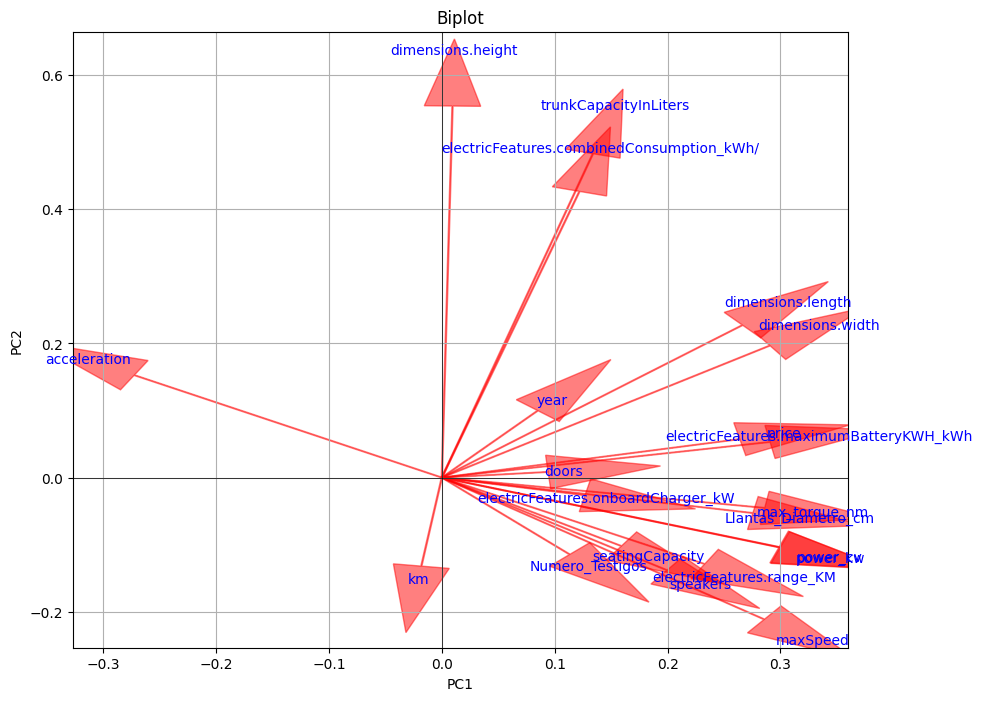

In [10]:
def biplot(score, coeff, labels=None):
    plt.figure(figsize=(10, 8))
    origin = [0, 0]  # Origen de las flechas

    # Dibujar las flechas
    for i in range(len(coeff)):
        plt.arrow(origin[0], origin[1], coeff[i,0], coeff[i,1], color='r', alpha=0.5, head_width=0.05, head_length=0.1)
        if labels is not None:
            plt.text(coeff[i,0]*1.15, coeff[i,1]*1.15, labels[i], color='blue', ha='center', va='center')

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Biplot")
    plt.grid(True)
    plt.axhline(0, color='black',linewidth=0.5)
    plt.axvline(0, color='black',linewidth=0.5)
    plt.xlim(min(coeff[:,0])*1.2, max(coeff[:,0])*1.2)
    plt.ylim(min(coeff[:,1])*1.2, max(coeff[:,1])*1.2)
    plt.show()

# Llamada a la función biplot
biplot(principal_components, np.transpose(pca.components_[0:2, :]), labels=numerical_columns.columns)

## Test CART regression trees with only numerical variables

In [11]:
X = numerical_columns.drop(columns="price")
y = numerical_columns["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

MAE: 3689.364538865394 
 MSE: 47478116.01571343 
 RMSE: 6890.436562055661 
 R2: 0.8832352442714952 
 MAPE: 10.853664293540138
Mean: 3689.364538865394
Variance: 33866705.315075964
Standard Deviation: 5819.510745335553


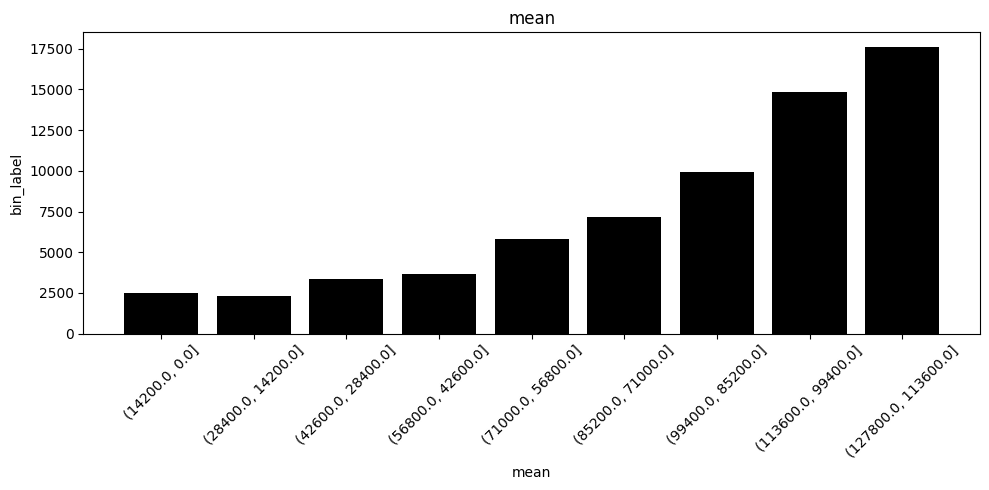

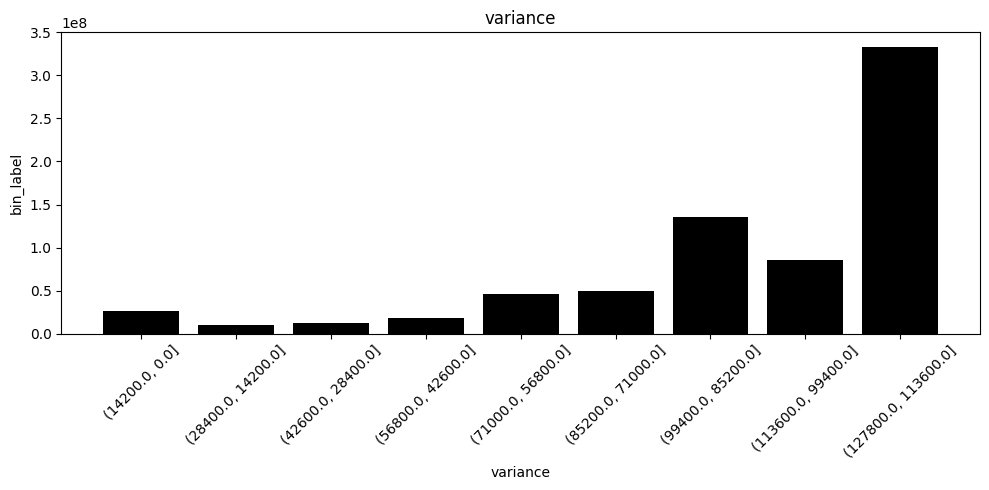

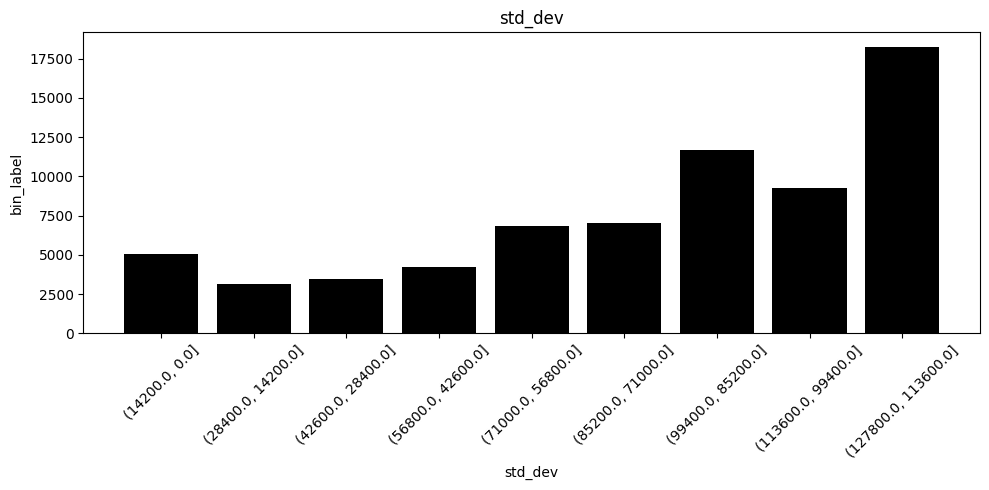

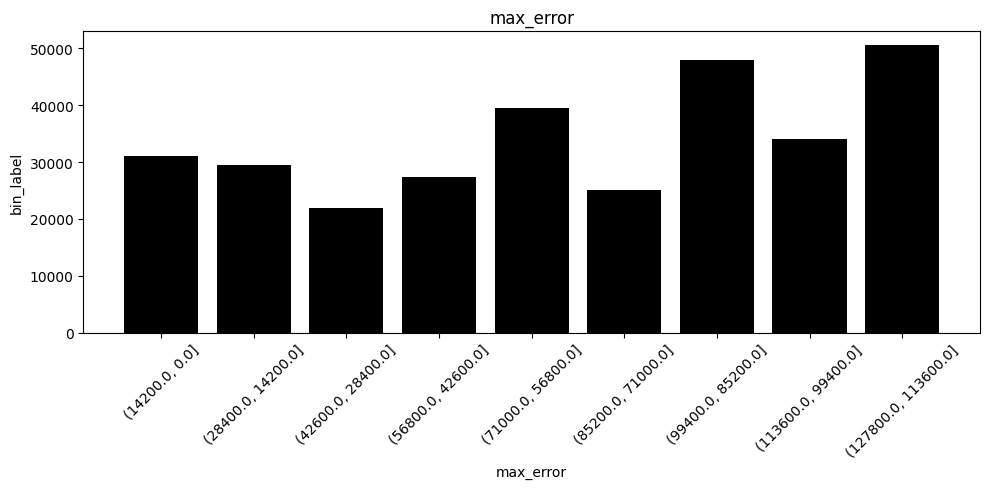

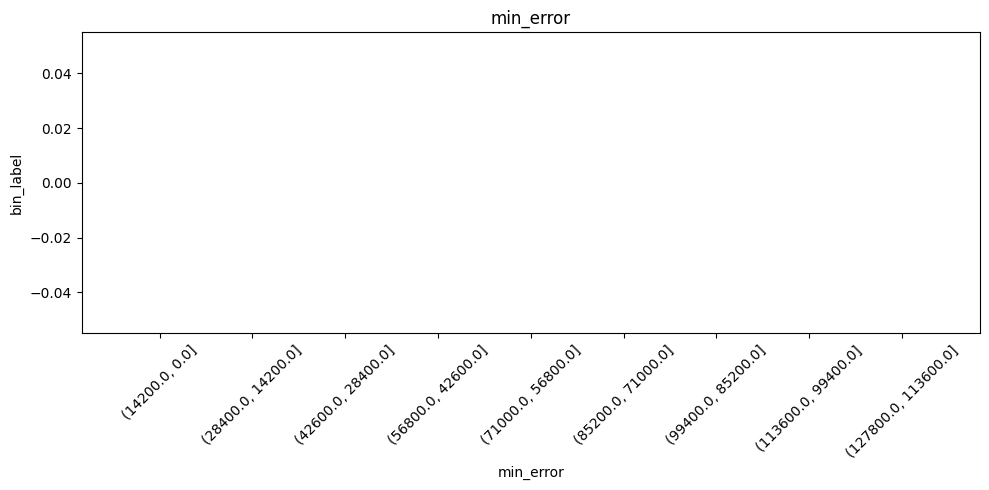

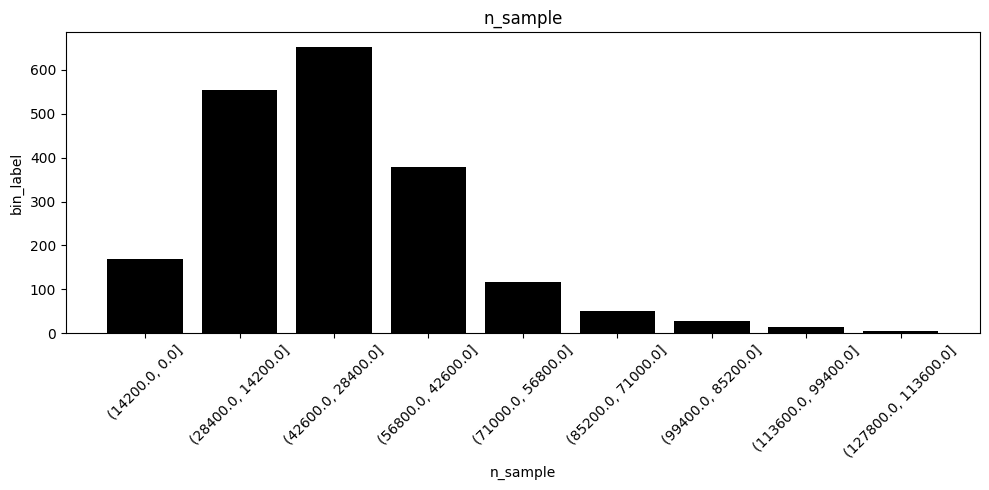

,bin_label,mean,variance,std_dev,max_error,min_error,n_sample
0,"(14200.0, 0.0]",2494.266272,2.569980e+07,5069.496735,31010.0,0.0,169
1,"(28400.0, 14200.0]",2311.775236,9.948983e+06,3154.200892,29513.0,0.0,554
2,"(42600.0, 28400.0]",3357.001466,1.188936e+07,3448.095069,22000.0,0.0,652
3,"(56800.0, 42600.0]",3656.278170,1.780634e+07,4219.755443,27339.0,0.0,379
4,"(71000.0, 56800.0]",5810.314440,4.651689e+07,6820.329516,39511.0,0.0,117
5,"(85200.0, 71000.0]",7150.871429,4.908265e+07,7005.901427,25122.0,0.0,50
6,"(99400.0, 85200.0]",9954.068966,1.357859e+08,11652.720784,47901.0,0.0,29
7,"(113600.0, 99400.0]",14825.011905,8.546177e+07,9244.553264,34000.0,0.0,14
8,"(127800.0, 113600.0]",17625.000000,3.334092e+08,18259.495019,50510.0,0.0,6


In [12]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Realizar predicciones sobre el conjunto de prueba
y_pred = tree_model.predict(X_test)

Evaluator.eval_regression(y_pred, y_test, plot= True, bins=10)

## Electrico categorical variables
Here we will perform CA and Chi2 test to select the best categorical variables

In [13]:
def get_electric_categorical_columns(df: pd.DataFrame) -> pd.DataFrame:
    ret = df.select_dtypes(include=['category'])
    ret = ret.drop(columns=["environmentalLabel"]) #All of the cars of this dataframes are electrical which implies 0 emission
    ret = Data_processor.remove_redundand_columns(ret)
    ret = Data_processor.impute_categorical_mode(df=ret, X=["brand", "model"], Y="version")
    ret = Data_processor.impute_categorical_mode(df=ret, X=["brand", "model"], Y="jato_classification")
    ret = Data_processor.impute_categorical_mode(df=ret, X=["brand", "model", "traction"], Y="brakes")
    ret = Data_processor.impute_categorical_mode(df=ret, X=["brand", "model", "traction","brakes"], Y="front_suspension")
    ret = Data_processor.impute_categorical_mode(df=ret, X=["brand", "model", "traction","brakes"], Y="rear_suspension")
    return ret

In [14]:
categorical_columns = get_electric_categorical_columns(data)
print("\nCategorical Columns Index:")
print(categorical_columns.index)


Categorical Columns Index:
Index([47362, 47511, 47535, 47559, 47603, 47617, 47858, 47988, 47989, 47997,
       ...
       94133, 94139, 94158, 94161, 94194, 94291, 94342, 94359, 94436, 94557],
      dtype='int64', name='idx', length=6591)


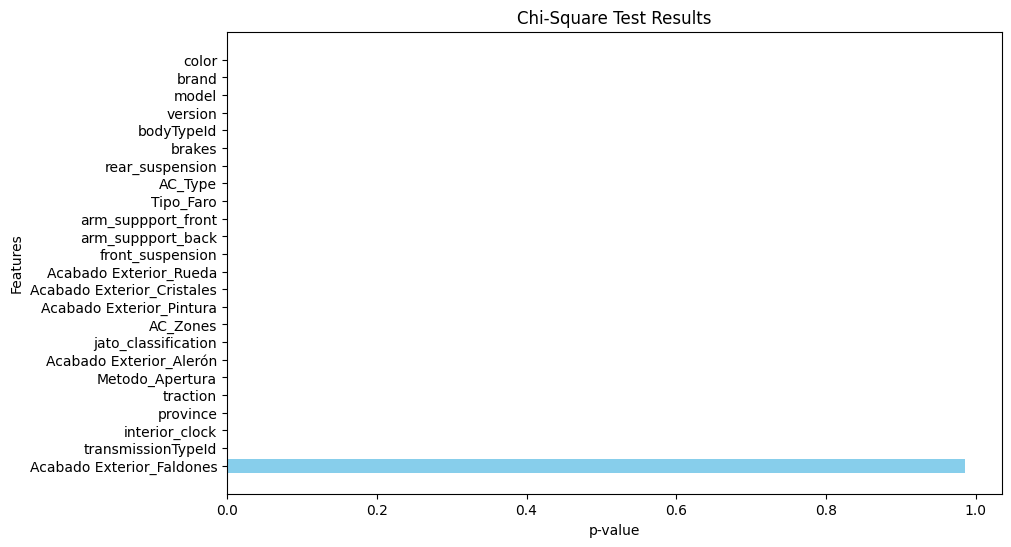

,Feature,Chi2 Stat,p-value
0,color,17355.917738,0.000000e+00
1,brand,1800.198086,0.000000e+00
2,model,15590.848906,0.000000e+00
3,version,19903.204434,0.000000e+00
4,bodyTypeId,6530.816750,0.000000e+00
9,brakes,1581.335781,0.000000e+00
11,rear_suspension,1848.387572,0.000000e+00
18,AC_Type,1486.737498,0.000000e+00
20,Tipo_Faro,1590.069687,0.000000e+00
22,arm_suppport_front,3759.181818,0.000000e+00


In [15]:
Data_processor.chi_square_test(categorical_columns=categorical_columns, column_y="price_categ")

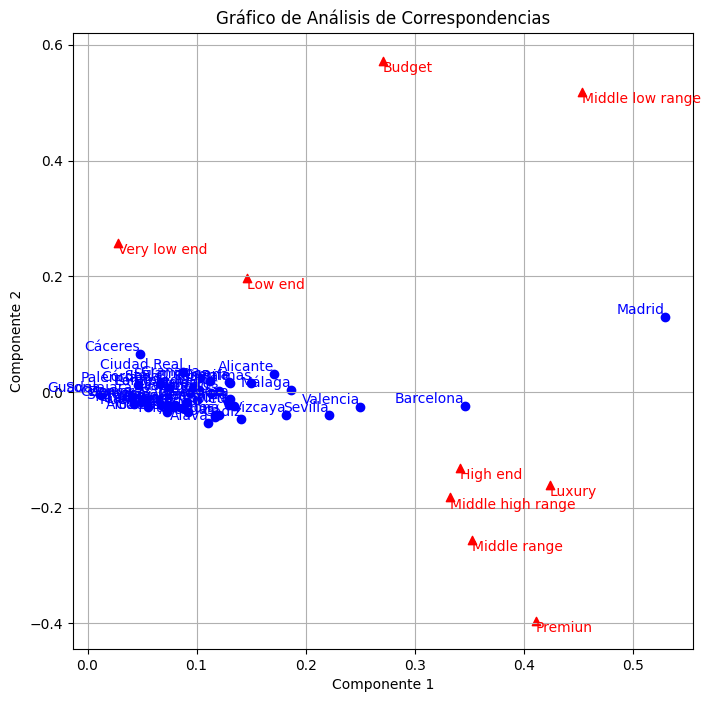

In [16]:
Data_processor.CA(categorical_columns=categorical_columns, col_x="province", col_y="price_categ")

In [17]:
categorical_columns["price_categ"].value_counts()

price_categ
Middle low range     1353
Luxury               1182
Premiun              1113
Middle range          820
High end              767
Middle high range     727
Budget                483
Low end               141
Very low end            5
Name: count, dtype: int64

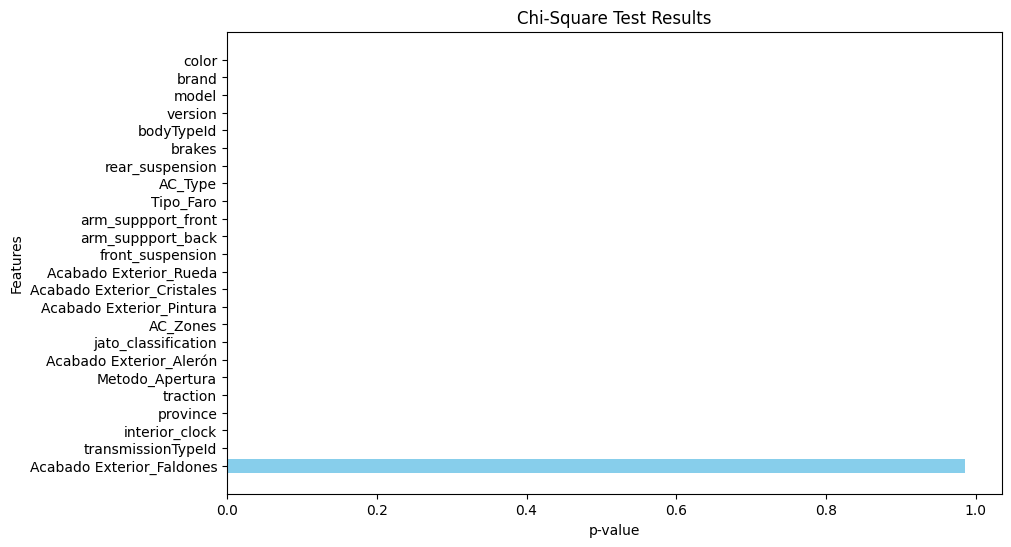

Index(['color', 'brand', 'model', 'version', 'bodyTypeId', 'brakes',
       'rear_suspension', 'AC_Type', 'Tipo_Faro', 'arm_suppport_front',
       'arm_suppport_back', 'price_categ'],
      dtype='object')

In [18]:
categorical_columns = Data_processor.chi_square_filter(categorical_columns, "price_categ", p_value_filter=0)
categorical_columns.columns

## Test CART tree classifier with only categorical values

In [19]:
features_df = pd.get_dummies(categorical_columns.drop('price_categ', axis=1))

# Your target variable
target = categorical_columns['price_categ'].apply(Loader.encode_price_categ)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_df, target, test_size=0.3, random_state=42)

# Initialize and train the Decision Tree Classifier
cart_model = DecisionTreeClassifier(random_state=42)
cart_model.fit(X_train, y_train)

# Predicting the test set results
y_pred = cart_model.predict(X_test)


In [20]:
result = pd.DataFrame({"Real_Categorie": y_test, "Prediction": y_pred})
result["diff"] = np.abs(result["Real_Categorie"].astype(int) - result["Prediction"])
result["Real_Categorie"] = result["Real_Categorie"].apply(Loader.decode_price_categ)
result["Prediction"] = result["Prediction"].apply(Loader.decode_price_categ)
result

,Real_Categorie,Prediction,diff
idx,,,
45867,Premiun,Middle high range,2
164049,Middle high range,Middle high range,0
7873,Premiun,Premiun,0
134505,Budget,Budget,0
16439,Luxury,Luxury,0
...,...,...,...
16322,Luxury,Luxury,0
60749,Premiun,Premiun,0
34691,High end,Premiun,1


In [21]:
# Calcular la precisión
Evaluator.eval_classfication(y_pred=result["Prediction"].to_numpy(), y_true=result["Real_Categorie"].to_numpy(), binary_classification=False)

Accuracy: 0.6203235591506572 
 Precision: 0.6195761164516269 
 Recall: 0.6203235591506572 
 F1 Score: 0.6160049803072201
Confusion Matrix:
 [[307   3   2   1  17  27  26   1   0]
 [ 13  94   0  12  46   0  19  65   0]
 [  1   0  29   0   1  14   1   0   0]
 [  8   6   0 255  11   0   1  73   0]
 [ 23  31   0   2  99   0  49  13   0]
 [ 32   0  14   0   0  92   0   3   0]
 [ 75  12   1   0  43   1 123   2   0]
 [  1  40   0  41  12   0   6 228   0]
 [  0   0   2   0   0   0   0   0   0]]


/home/lingfeng/Desktop/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


We can verify that the prediction is not very accurate but we need to know how big is the error.

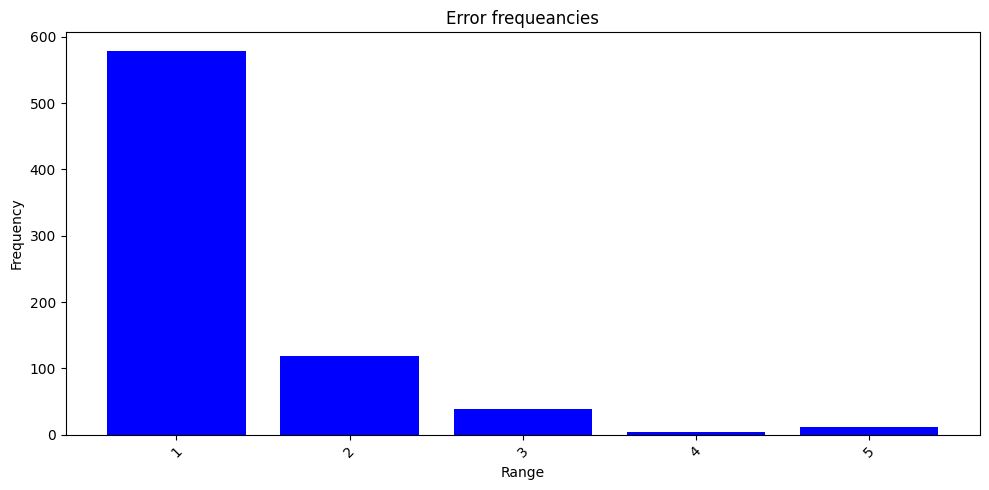

{1: 578, 2: 118, 3: 39, 4: 4, 5: 12}
Error mean: 1.340878828229028
Error rate: 37.96764408493428 %
Overall mean: 0.5091001011122346


In [22]:
Evaluator.eval_ordinal_classification (result["diff"])

Even having errors, we can verify that the errors are not that big

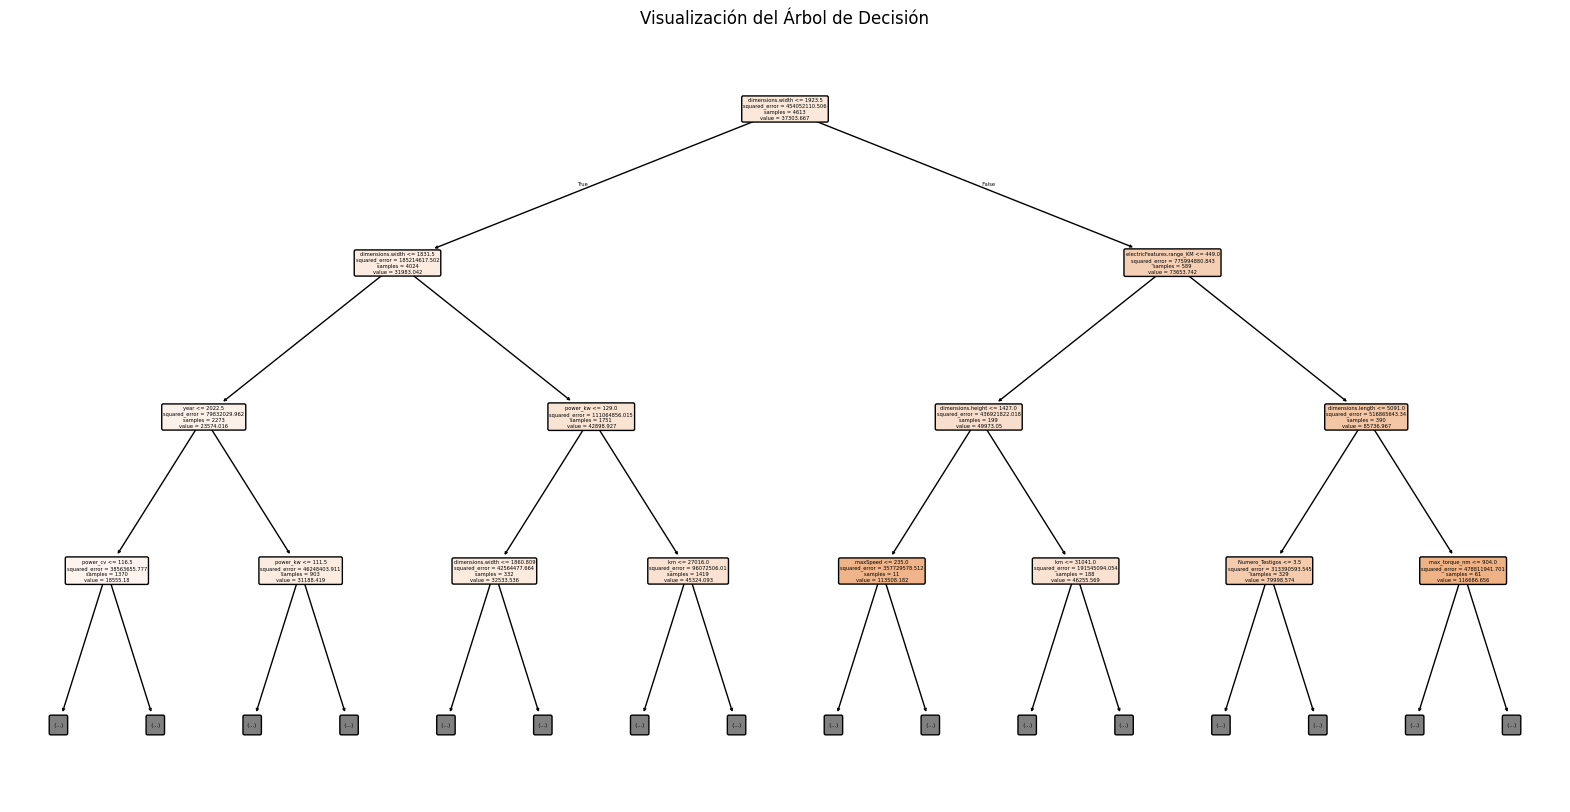

In [23]:
plt.figure(figsize=(20,10))

# Dibujar el árbol de decisión
plot_tree(tree_model, 
          filled=True, 
          rounded=True, 
          class_names=X_train.columns, 
          feature_names=X.columns, 
          max_depth=3)  # Puedes ajustar la profundidad para una mejor visualización o quitar este parámetro para mostrar todo el árbol
plt.title('Visualización del Árbol de Decisión')
plt.show()

# Agorithms evaluation

In [24]:
electric_cars = pd.merge(numerical_columns, categorical_columns, left_index=True, right_index=True, how='inner')
numerical_column_names = list(numerical_columns.columns)
categorical_column_names = list(categorical_columns.columns)

target = electric_cars[["price", "price_categ"]]
electric_cars.drop(columns=["price", "price_categ"], inplace=True)


numerical_column_names.remove("price")
categorical_column_names.remove("price_categ")

encoders_and_scalers = {}
for column in numerical_column_names:
    scaler = StandardScaler()
    electric_cars[[column]] = scaler.fit_transform(electric_cars[[column]])
    encoders_and_scalers[column] = scaler 

electric_cars_encoded = pd.get_dummies(electric_cars, columns=categorical_column_names)

## Classification

In [25]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(electric_cars_encoded, target['price_categ'], test_size=0.3, random_state=42)

In [26]:
def eval_classification(y_test, y_pred):
    result = pd.DataFrame({"Real": y_test, "Prediction": y_pred})
    result["diff"] = result["Real"].apply(Loader.encode_price_categ).to_numpy() - result["Prediction"].apply(Loader.encode_price_categ).to_numpy()
    Evaluator.eval_ordinal_classification(diff=result["diff"])

def classify(X_train, X_test, y_train, y_test , classifier) -> None:
    classifier = classifier
    classifier.fit(X_train, y_train)

    # Predicting the test set results
    y_pred = classifier.predict(X_test)
    eval_classification(y_test, y_pred)
    Evaluator.eval_classfication(y_pred = y_pred, y_true=y_test, binary_classification=False)



### CART

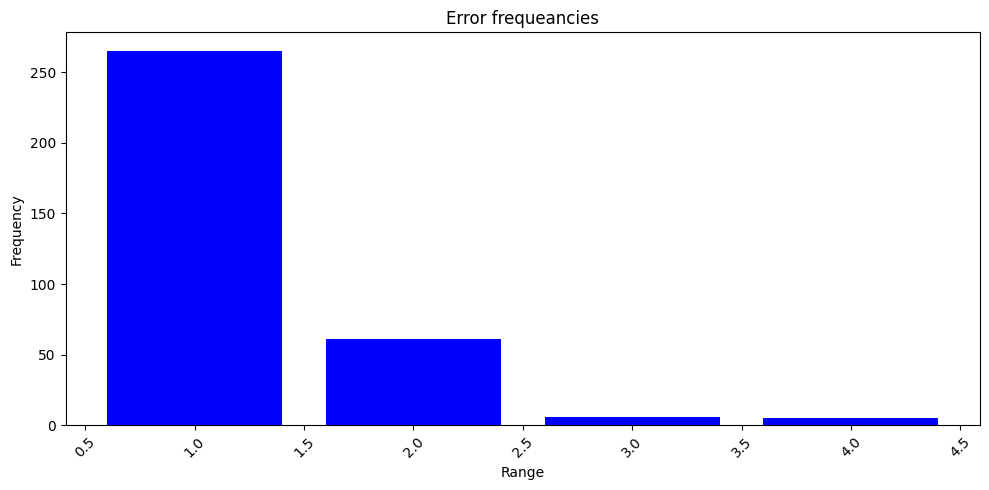

{1: 265, 2: 61, 3: 6, 4: 5}
Error mean: 1.261127596439169
Error rate: 17.03741152679474 %
Overall mean: 0.03488372093023256
Accuracy: 0.6779575328614762 
 Precision: 0.6800045079147727 
 Recall: 0.6779575328614762 
 F1 Score: 0.6775809364917618
Confusion Matrix:
 [[ 99   0  17   0   0  22   3   0   0]
 [  0 124   0   2  40   2  24  57   0]
 [ 11   0  31   0   1   1   1   0   1]
 [  0   6   0 286   3   0   4  55   0]
 [  0  37   0   0 122  18  30  10   0]
 [ 24   2   1   0  13 310  34   0   0]
 [  1  14   0   0  55  55 131   1   0]
 [  0  43   0  34  11   1   1 238   0]
 [  2   0   0   0   0   0   0   0   0]]


In [27]:
classify(X_train, X_test, y_train, y_test, DecisionTreeClassifier(random_state=42))

### Random forest
Random forest can get a better result at a higher computational time cost

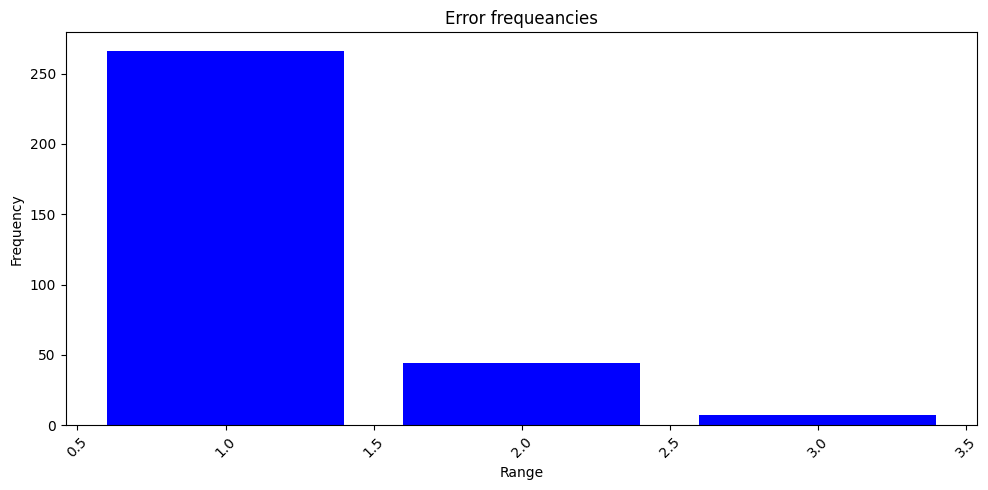

{1: 266, 2: 44, 3: 7}
Error mean: 1.1829652996845426
Error rate: 16.0262891809909 %
Overall mean: 0.014661274014155713
Accuracy: 0.6971688574317493 
 Precision: 0.6989269313469633 
 Recall: 0.6971688574317493 
 F1 Score: 0.6954119062833369
Confusion Matrix:
 [[ 98   0  14   3   0  26   0   0   0]
 [  0 120   0   2  41   5  18  63   0]
 [  8   0  36   1   1   0   0   0   0]
 [  0   4   0 285   1   0   0  64   0]
 [  0  25   0   1 133  12  33  13   0]
 [ 17   1   1   0  11 318  36   0   0]
 [  0   6   0   0  46  56 148   1   0]
 [  0  41   0  36   9   0   1 241   0]
 [  2   0   0   0   0   0   0   0   0]]


/home/lingfeng/Desktop/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [28]:
classify(X_train, X_test, y_train, y_test, RandomForestClassifier(random_state=42))

### SVM
Much higher computational cost, more distributed error, but in overall worse result

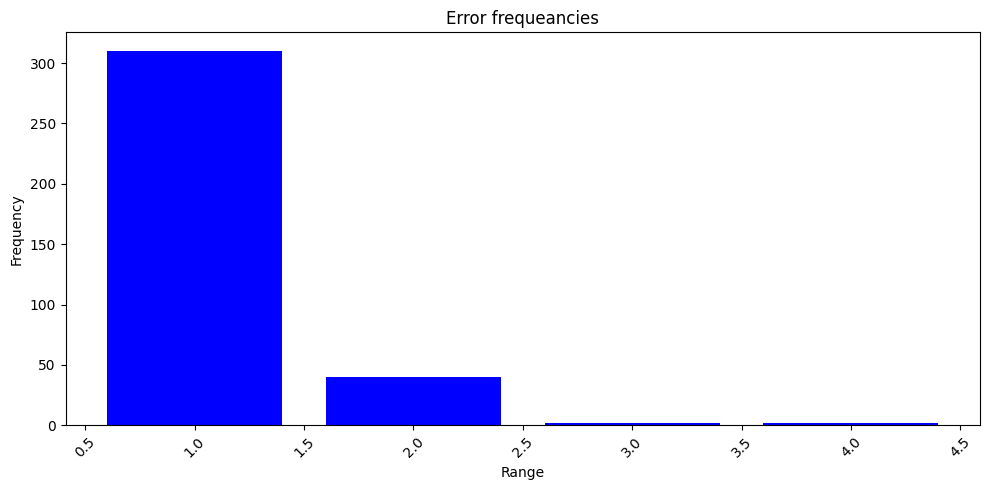

{1: 310, 2: 40, 3: 2, 4: 2}
Error mean: 1.1412429378531073
Error rate: 17.89686552072801 %
Overall mean: 0.028311425682507583
Accuracy: 0.6683518705763397 
 Precision: 0.6732526199513528 
 Recall: 0.6683518705763397 
 F1 Score: 0.6640837835746289
Confusion Matrix:
 [[107   0   5   0   0  29   0   0   0]
 [  0  95   0   4  50   1  26  73   0]
 [ 17   0  26   1   0   1   1   0   0]
 [  0   3   0 258   0   0   1  92   0]
 [  0  46   0   1  98   4  57  11   0]
 [ 24   0   0   0   3 319  38   0   0]
 [  0   5   0   1  40  54 153   4   0]
 [  0  28   0  25   7   1   1 266   0]
 [  1   0   1   0   0   0   0   0   0]]


/home/lingfeng/Desktop/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [29]:
classify(X_train, X_test, y_train, y_test, SVC(random_state=42))

### Naive bayes

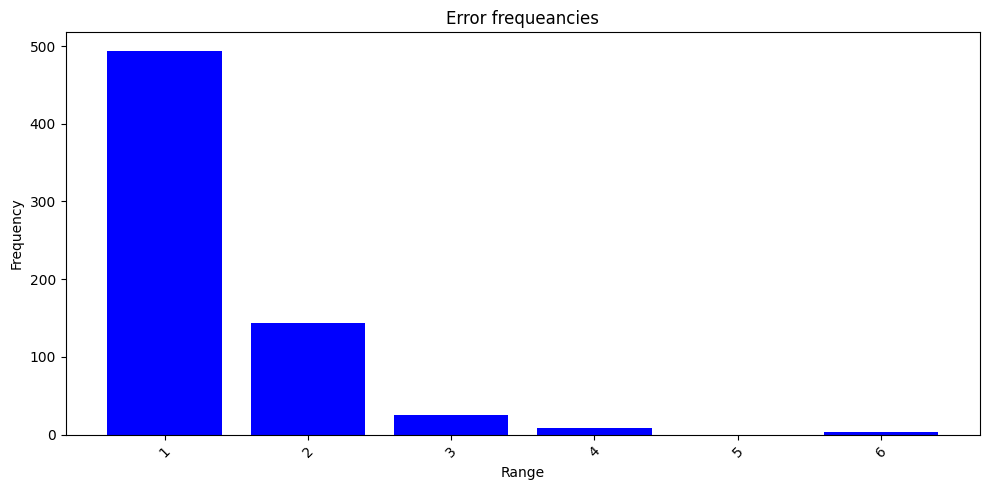

{1: 493, 2: 144, 3: 25, 4: 8, 6: 3}
Error mean: 1.3462109955423478
Error rate: 34.02426693629929 %
Overall mean: 0.28361981799797775
Accuracy: 0.5080889787664308 
 Precision: 0.5921329294665278 
 Recall: 0.5080889787664308 
 F1 Score: 0.49930559726653345
Confusion Matrix:
 [[ 93   0  37   0   0   8   3   0   0]
 [  1 116   0   6  61   1  49  15   0]
 [  4   0  39   0   1   1   0   0   1]
 [  2  43   0 275   9   0   7  18   0]
 [  1  35   0   1  87   3  88   2   0]
 [119   1  18   0  17 107 121   1   0]
 [ 12   6   2   0  22  19 196   0   0]
 [  0 150   1  54  19   0  12  92   0]
 [  0   0   2   0   0   0   0   0   0]]


In [30]:
classify(X_train, X_test, y_train, y_test, GaussianNB())

## Regression

In [31]:
X_train, X_test, y_train, y_test = train_test_split(electric_cars_encoded, target['price'], test_size=0.3, random_state=42)

In [32]:
def regression(X_train, X_test, y_train, y_test , regressor) -> None:
    regressor = regressor
    regressor.fit(X_train, y_train)

    # Predicting the test set results
    y_pred = regressor.predict(X_test)
    Evaluator.eval_regression(y_pred = y_pred, y_true=y_test, plot=False)

### Cart

In [33]:
regression(X_train, X_test, y_train, y_test , DecisionTreeRegressor(random_state=42))

MAE: 3779.709504550051 
 MSE: 66425722.94060583 
 RMSE: 8150.197724019082 
 R2: 0.836636666234141 
 MAPE: 10.74808886793191
Mean: 3779.709504550051
Variance: 52139519.00181985
Standard Deviation: 7220.769972919775


### RandomForest

In [34]:
regression(X_train, X_test, y_train, y_test , RandomForestRegressor(random_state=42))

MAE: 3161.0431436173435 
 MSE: 38819476.80534466 
 RMSE: 6230.527811136442 
 R2: 0.9045297685109439 
 MAPE: 9.288193854428119
Mean: 3161.0431436173435
Variance: 28827283.04953446
Standard Deviation: 5369.1044923277905


### SVM Regression

In [35]:
regression(X_train, X_test, y_train, y_test , SVR(kernel='rbf'))

MAE: 14119.388951835681 
 MSE: 409323917.30752903 
 RMSE: 20231.755171203735 
 R2: -0.00666604383438707 
 MAPE: 49.30057595419943
Mean: 14119.388951835681
Variance: 209966772.93430963
Standard Deviation: 14490.230258153582


Mu

### Multivariable regression

In [36]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

# Predicting the test set results
y_pred = linear_regressor.predict(X_test)

# Optionally, display the coefficients of the model
print("Coefficients:", linear_regressor.coef_)
print("Intercept:", linear_regressor.intercept_)

Coefficients: [-1.98321321e+03  5.51444526e+03 -3.16164906e+03 ...  0.00000000e+00
  0.00000000e+00  2.35037256e+14]
Intercept: -410475248287377.5


In [37]:
result = pd.DataFrame({"Real": y_test, "Prediction": y_pred})
result["diff"] = result["Real"].to_numpy() - result["Prediction"].to_numpy()

In [47]:
result

,Real,Prediction,diff
idx,,,
45867,44822,3.681350e+04,8.008500e+03
164049,31490,3.134788e+04,1.421250e+02
7873,48850,5.541112e+04,-6.561125e+03
134505,24000,2.139869e+04,2.601312e+03
16439,54900,2.984423e+13,-2.984423e+13
...,...,...,...
16322,66900,4.159533e+12,-4.159533e+12
60749,40900,4.547619e+04,-4.576188e+03
34691,39900,3.903875e+04,8.612500e+02
